In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


In [3]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('리뷰의 최대 길이 :', np.max(num_tokens))
print('리뷰의 평균 길이 :', np.mean(num_tokens))
print('리뷰의 표준편차 : ', np.std(num_tokens))

리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 15.96940191154864
리뷰의 표준편차 :  12.843571191092


In [7]:
#평균 +2 표준편차로 길이설정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

In [9]:
#패딩은 pre가 유리함.

x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


# 모델설계 LSTM

In [10]:
vocab_size = 10000
word_vector_dim = 16

LSTM = keras.Sequential()
LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM.add(keras.layers.LSTM(256))
LSTM.add(keras.layers.Dense(256, activation='relu'))
LSTM.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               279552    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 505,601
Trainable params: 505,601
Non-trainable params: 0
_________________________________________________________________


In [11]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


# Conv1D


In [12]:
Conv1D = keras.Sequential()
Conv1D.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
Conv1D.add(keras.layers.Conv1D(16, 7, activation='relu'))
Conv1D.add(keras.layers.MaxPooling1D(5))
Conv1D.add(keras.layers.Conv1D(16, 7, activation='relu'))
Conv1D.add(keras.layers.GlobalMaxPooling1D())
Conv1D.add(keras.layers.Dense(8, activation='relu'))
Conv1D.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

Conv1D.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

# Global

In [13]:
Global = keras.Sequential()
Global.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
Global.add(keras.layers.GlobalMaxPooling1D())
Global.add(keras.layers.Dense(8, activation='relu'))
Global.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

Global.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [14]:
              
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_LSTM = LSTM.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)


Conv1D.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_Conv1D = Conv1D.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)


Global.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_Global = Global.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)


Epoch 1/7
266/266 [==============================] - 15s 44ms/step - loss: 0.5161 - accuracy: 0.7336 - val_loss: 0.3482 - val_accuracy: 0.8485
Epoch 2/7
266/266 [==============================] - 11s 42ms/step - loss: 0.3283 - accuracy: 0.8616 - val_loss: 0.3354 - val_accuracy: 0.8539
Epoch 3/7
266/266 [==============================] - 11s 42ms/step - loss: 0.2938 - accuracy: 0.8779 - val_loss: 0.3274 - val_accuracy: 0.8563
Epoch 4/7
266/266 [==============================] - 11s 42ms/step - loss: 0.2691 - accuracy: 0.8900 - val_loss: 0.3307 - val_accuracy: 0.8618
Epoch 5/7
266/266 [==============================] - 11s 42ms/step - loss: 0.2468 - accuracy: 0.8995 - val_loss: 0.3317 - val_accuracy: 0.8590
Epoch 6/7
266/266 [==============================] - 11s 42ms/step - loss: 0.2266 - accuracy: 0.9081 - val_loss: 0.3491 - val_accuracy: 0.8574
Epoch 7/7
266/266 [==============================] - 11s 42ms/step - loss: 0.2085 - accuracy: 0.9167 - val_loss: 0.3837 - val_accuracy: 0.8527

In [15]:
def draw_chart(history):
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.clf()

    plt.plot(epochs, acc, 'bo', label='Training acc') # "bo"는 "파란색 점"
    plt.plot(epochs, val_acc, 'b', label='Validation acc') # b는 "파란 실선"
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    


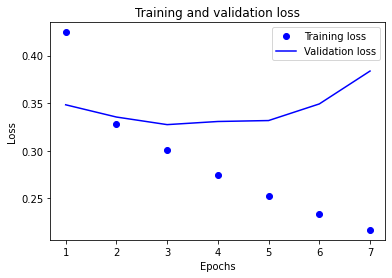

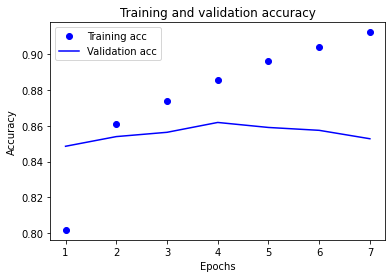

In [16]:
draw_chart(history_LSTM)

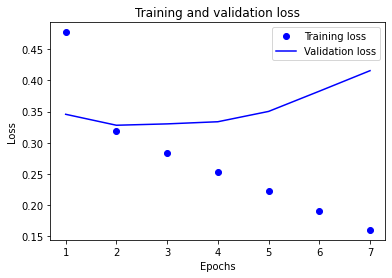

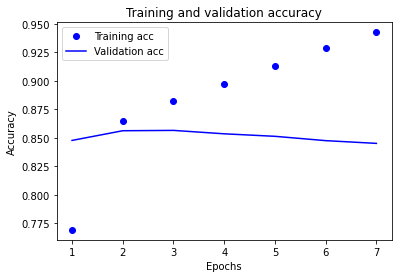

In [17]:
draw_chart(history_Conv1D)

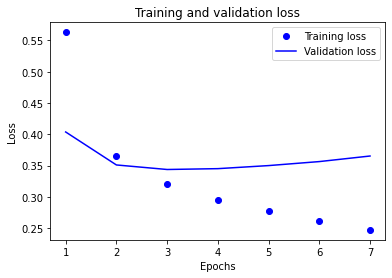

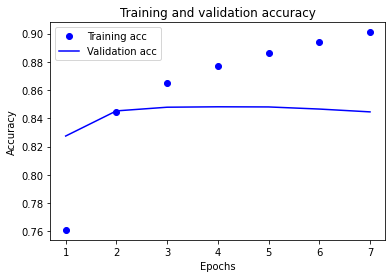

In [18]:
draw_chart(history_Global)

In [19]:
results_LSTM = LSTM.evaluate(x_test, y_test, verbose=2)
print(results_LSTM)



1537/1537 - 7s - loss: 0.3948 - accuracy: 0.8501
[0.39477968215942383, 0.8501129150390625]


In [20]:
results_Conv1D = Conv1D.evaluate(x_test, y_test, verbose=2)
print(results_Conv1D)

results_Global = Global.evaluate(x_test, y_test, verbose=2)
print(results_Global)

1537/1537 - 5s - loss: 0.4284 - accuracy: 0.8433
[0.4283839166164398, 0.8432980179786682]
1537/1537 - 2s - loss: 0.3800 - accuracy: 0.8425
[0.3799535930156708, 0.8425453305244446]


# Gensim 분석

In [21]:
import os

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = Global.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()



In [22]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [23]:
word2vec.similar_by_word("소름")

[('~!!!', 0.9360668063163757),
 ('맛있', 0.9230650067329407),
 ('학도', 0.912503719329834),
 ('1998', 0.9104383587837219),
 ('조니뎁', 0.9083309173583984),
 ('파란', 0.9026524424552917),
 ('참된', 0.9022834897041321),
 ('엑스맨', 0.8960534930229187),
 ('교과서', 0.8873232007026672),
 ('예뻐', 0.8860265612602234)]

# 한국어 Word2Vec 임베딩 활용하여 성능개선

In [34]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.7/site-packages/gensim/models/word2vec.py'>

In [24]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

ValueError: could not broadcast input array from shape (16) into shape (200)

In [ ]:
model_word2vec = keras.Sequential()
model_word2vec.add(keras.layers.Embedding(vocab_size, word_vector_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))  
model_word2vec.add(keras.layers.LSTM(256))
model_word2vec.add(keras.layers.Dense(256, activation='relu'))
model_word2vec.add(keras.layers.Dense(1, activation='sigmoid'))

model_word2vec.summary()

In [ ]:
model_word2vec.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

history_word2vec = model_word2vec.fit(x_train_split, y_train_split, epochs=10, batch_size=64, validation_data=(x_val, y_val), verbose=1)

In [ ]:
results_word2vec = model_word2vec.evaluate(X_test,  y_test, verbose=2)

print(results_word2vec)

In [ ]:
draw_chart(history_word2vec)